## 1. Setup

In [91]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [104]:
# Configuration
print(os.path.exists(r'../../data/combined_data.csv'))
INPUT_FILE = '../../data/combined_data.csv' # The csv file for now but later will be changed to use data from db?
OUTPUT_FILE = '../../data/combined_data_cleaned.csv' # Will output the cleaned data in a separate csv file

# To track cleaning stats - how many rows were removed and why
cleaning_report = {
    'original_row_count': 0,
    'removed_missing_labels': 0,
    'removed_duplicates': 0,
    'removed_empty_statements': 0,
    'removed_invalid_labels': 0,
    'final_row_count': 0
}

True


## 2. Load and Check the Data

In [93]:
# Load the dataset
df = pd.read_csv(INPUT_FILE)
cleaning_report['original_row_count'] = len(df)

print(f"Loaded dataset with {len(df):,} rows and {len(df.columns)} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")

# Preview the data
print(df.head(10))
print(df.tail(10))

Loaded dataset with 53,043 rows and 3 columns

Columns: ['Unnamed: 0', 'statement', 'status']

Data types:
Unnamed: 0     int64
statement     object
status        object
dtype: object
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety
5           5  every break, you must be nervous, like somethi...  Anxiety
6           6  I feel scared, anxious, what can I do? And may...  Anxiety
7           7    Have you ever felt nervous but didn't know why?  Anxiety
8           8  I haven't slept well for 2 days, it's like I'm...  Anxiety
9           9                 I'm really worried, I want to cry.  Anxiety
  

In [94]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [95]:
# Check label distribution
print("\nOriginal label distribution:")
print(df['status'].value_counts())

# Label distribution as value counts
print("\nFinal label distribution:")
orig_label_dist = df['status'].value_counts()
print(orig_label_dist)

# Label distribution as percentages
print("\nAs percentages:")
print((orig_label_dist / len(df) * 100).round(2))


Original label distribution:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

Final label distribution:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

As percentages:
status
Normal                  30.83
Depression              29.04
Suicidal                20.08
Anxiety                  7.33
Bipolar                  5.42
Stress                   5.03
Personality disorder     2.26
Name: count, dtype: float64


## 3. Data Cleaning

### 3.1 Drop unneeded features

In [96]:
# Drop the ID column which is unnamed (if exists)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    print("Dropped ID column")

print(f"Remaining columns: {list(df.columns)}")

Dropped ID column
Remaining columns: ['statement', 'status']


### 3.2 Remove rows with missing labels

In [97]:
# Remove rows with missing labels (should be 0 in the original dataset, but may be useful for something later)
initial_count = len(df)
df = df.dropna(subset=['status'])
removed = initial_count - len(df)
cleaning_report['removed_missing_labels'] = removed

print(f"Removed {removed:,} rows with missing labels")
print(f"Remaining number of rows: {len(df):,}")

Removed 0 rows with missing labels
Remaining number of rows: 53,043


### 3.3 Remove rows with missing statements

In [98]:
initial_count = len(df)

# Remove rows with missing statements
df = df.dropna(subset=['statement'])

# Remove statements that are just whitespace
df['statement'] = df['statement'].astype(str)
df = df[df['statement'].str.strip() != '']

removed = initial_count - len(df)
cleaning_report['removed_empty_statements'] = removed

print(f"Removed {removed:,} rows with empty statements")
print(f"Remaining number of rows: {len(df):,}")

Removed 362 rows with empty statements
Remaining number of rows: 52,681


### 3.4 Remove rows with Personality Disorder label

In [99]:
# Remove Personality Disorder label as it is severely underrepresented in the dataset
VALID_LABELS = [
    'Normal', 'Depression', 'Suicidal', 'Anxiety',
    'Stress', 'Bipolar'
]

# Check to make sure which labels will be removed and how many rows they have
invalid_labels = df[~df['status'].isin(VALID_LABELS)]['status'].value_counts()
print("Labels to be removed:")
print(invalid_labels)

initial_count = len(df)
df = df[df['status'].isin(VALID_LABELS)]
removed = initial_count - len(df)
cleaning_report['removed_invalid_labels'] = removed

print(f"\nRemoved {removed:,} rows with invalid labels")
print(f"Remaining number of rows: {len(df):,}")

Labels to be removed:
status
Personality disorder    1077
Name: count, dtype: int64

Removed 1,077 rows with invalid labels
Remaining number of rows: 51,604


### 3.5 Remove rows with duplicate statement text

In [100]:
# Check how many duplicates exist
duplicate_count = df['statement'].duplicated().sum()
print(f"Number of duplicate statements: {duplicate_count:,}")

# Show 10 examples of duplicates if there are any
if duplicate_count > 0:
    duplicates = df[df['statement'].duplicated(keep=False)].sort_values('statement')
    print("\nExample duplicates:")
    print(duplicates.head(10))

# Remove the duplicated lines (keep the first occurrence of each)
initial_count = len(df)
df = df.drop_duplicates(subset=['statement'], keep='first')
removed = initial_count - len(df)
cleaning_report['removed_duplicates'] = removed

print(f"\nRemoved {removed:,} duplicate statements")
print(f"Remaining rows: {len(df):,}")

Number of duplicate statements: 1,426

Example duplicates:
                                               statement   status
52041  "Buy Friends" comment? My mother doesn't have ...  Anxiety
53027  "Buy Friends" comment? My mother doesn't have ...  Anxiety
49300  "Desk Toys for Your Stressful Day!"  \n\nDesk ...   Stress
48420  "Desk Toys for Your Stressful Day!"  \n\nDesk ...   Stress
504    "No regrets or grudges/angry at things that ha...  Anxiety
452    "No regrets or grudges/angry at things that ha...  Anxiety
309    "No regrets or grudges/angry at things that ha...  Anxiety
18     "No regrets or grudges/angry at things that ha...  Anxiety
97     "No regrets or grudges/angry at things that ha...  Anxiety
48468  "Reduce Worry and Chill Out – The Best Gummies...   Stress

Removed 1,426 duplicate statements
Remaining rows: 50,178


### 3.6 Reset the row indeces

In [101]:
df = df.reset_index(drop=True)
cleaning_report['final_count'] = len(df)
print(f"Fixed row indeces\nNumber of rows in the new dataset: {len(df):,}")
print(df.head())
print(df.tail())

Fixed row indeces
Number of rows in the new dataset: 50,178
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety
                                               statement   status
50173  Anxiety cause faintness when standing up ? As ...  Anxiety
50174  anxiety heart symptom does anyone else have th...  Anxiety
50175  Travel Anxiety Hi all! Long time anxiety suffe...  Anxiety
50176  fomo from things i’m not involved in does anyo...  Anxiety
50177  Getting through the day How do you get  anythi...  Anxiety


## 4. Check the Cleaned Dataset

In [102]:
# Dataset shape
print(f"Cleaned dataset shape: {df.shape}")

# Features in the dataset
print(f"Columns: {list(df.columns)}")

# Label distribution as value counts
print("\nFinal label distribution:")
label_dist = df['status'].value_counts()
print(label_dist)

# Label distribution as percentages
print("\nAs percentages:")
print((label_dist / len(df) * 100).round(2))

Cleaned dataset shape: (50178, 2)
Columns: ['statement', 'status']

Final label distribution:
status
Normal        16039
Depression    15087
Suicidal      10641
Anxiety        3617
Bipolar        2501
Stress         2293
Name: count, dtype: int64

As percentages:
status
Normal        31.96
Depression    30.07
Suicidal      21.21
Anxiety        7.21
Bipolar        4.98
Stress         4.57
Name: count, dtype: float64


## 5. Visualize the Cleaned Data

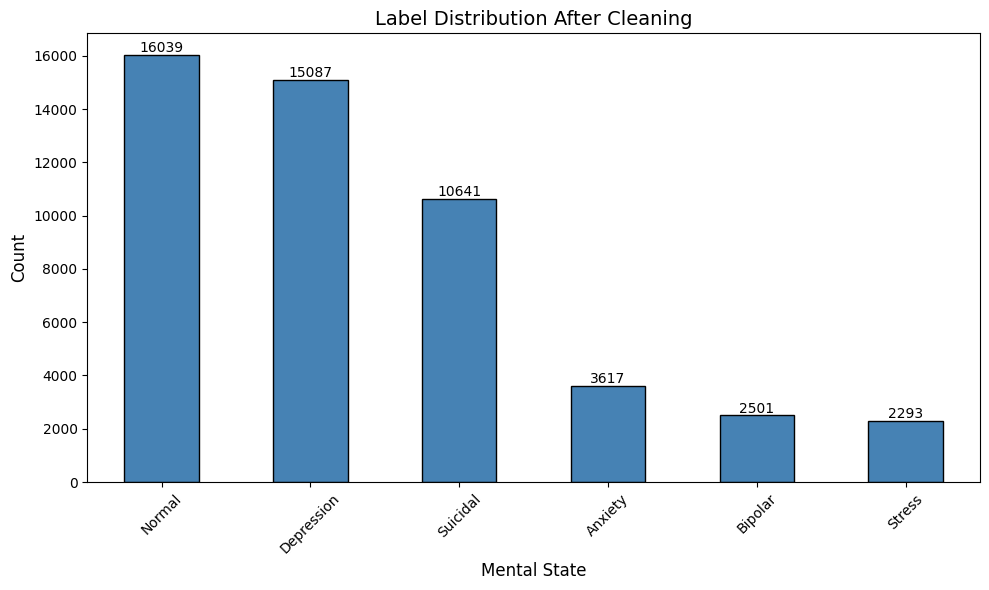

In [103]:
# Visualize label distribution
fig, ax = plt.subplots(figsize=(10, 6))
label_dist.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Label Distribution After Cleaning', fontsize=14)
ax.set_xlabel('Mental State', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', rotation=45)

for i, v in enumerate(label_dist):
    ax.text(i, v + 100, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Save the Cleaned Data

In [105]:
# Save new dataset to output file path
df.to_csv(OUTPUT_FILE, index=False)
print(f"Cleaned dataset saved to '{OUTPUT_FILE}'")

Cleaned dataset saved to '../../data/combined_data_cleaned.csv'
